In [111]:
#import modules
import json
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, models, datasets
from torchsummary import summary

In [36]:
#Data Transformation
IMAGE_SIZE = 64
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # since we have different images with different channels
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [37]:
train_dataset = torchvision.datasets.ImageFolder(root='../cat_pig_guess/data/train',
                                                 transform=data_transforms)
valid_dataset = torchvision.datasets.ImageFolder(root='../cat_pig_guess/data/valid',
                                                 transform=data_transforms)

In [38]:
img, target = next(iter(train_dataset))
print(f"Image data type: {type(img)}")
print(f"     Image size: {img.shape}")

Image data type: <class 'torch.Tensor'>
     Image size: torch.Size([3, 64, 64])


In [39]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False)

In [40]:
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False)

In [64]:
# define extra layer for densenet
extra_layer = nn.Sequential(OrderedDict([('layer1', nn.Linear(1024, 500)),
                                         ('relu1', nn.ReLU()),
                                         ('layer2', nn.Linear(500, 1))]))

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
# Code aspired from Tomas Beuzen

def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    for epoch in range(epochs):
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            y_hat = model(X).flatten()  # Forward pass to get output
            y_hat_labels = torch.sigmoid(y_hat) > 0.5        # convert probabilities to False (0) and True (1)
            loss = criterion(y_hat, y.type(torch.float32))   # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()   # Average accuracy for this batch
        train_loss.append(train_batch_loss / len(trainloader))     # loss = total loss in epoch / number of batches = loss per batch
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # Validation
        model.eval()  # this turns off those random dropout layers, we don't want them for validation!
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                X, y = X.to(device), y.to(device)
                y_hat = model(X).flatten()  # Forward pass to get output
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.type(torch.float32))   # Calculate loss based on output
                valid_batch_loss += loss.item()                  # Add loss for this batch to running total
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()   # Average accuracy for this batch  
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        model.train()  # turn back on the dropout layers for the next training loop
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")

    
    results = {"train_accuracy": train_accuracy,
               "valid_accuracy": valid_accuracy}
    return results

In [66]:
densenet2 = models.densenet121(pretrained=True)
densenet2.classifier = extra_layer
densenet2.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(densenet2.parameters())
results = trainer(densenet2, criterion, optimizer, train_loader, valid_loader, epochs = 20)

Epoch 1: Train Accuracy: 0.65. Valid Accuracy: 0.53.
Epoch 2: Train Accuracy: 0.81. Valid Accuracy: 0.55.
Epoch 3: Train Accuracy: 0.83. Valid Accuracy: 0.58.
Epoch 4: Train Accuracy: 0.88. Valid Accuracy: 0.68.
Epoch 5: Train Accuracy: 0.94. Valid Accuracy: 0.72.
Epoch 6: Train Accuracy: 0.91. Valid Accuracy: 0.79.
Epoch 7: Train Accuracy: 0.92. Valid Accuracy: 0.71.
Epoch 8: Train Accuracy: 0.97. Valid Accuracy: 0.77.
Epoch 9: Train Accuracy: 0.95. Valid Accuracy: 0.78.
Epoch 10: Train Accuracy: 0.97. Valid Accuracy: 0.80.
Epoch 11: Train Accuracy: 0.97. Valid Accuracy: 0.76.
Epoch 12: Train Accuracy: 0.99. Valid Accuracy: 0.80.
Epoch 13: Train Accuracy: 0.97. Valid Accuracy: 0.90.
Epoch 14: Train Accuracy: 0.97. Valid Accuracy: 0.87.
Epoch 15: Train Accuracy: 0.98. Valid Accuracy: 0.84.
Epoch 16: Train Accuracy: 0.92. Valid Accuracy: 0.78.
Epoch 17: Train Accuracy: 0.99. Valid Accuracy: 0.86.
Epoch 18: Train Accuracy: 0.99. Valid Accuracy: 0.86.
Epoch 19: Train Accuracy: 0.97. Valid

In [108]:
densenet2.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

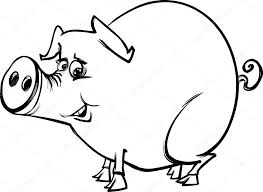

In [106]:
image = Image.open('../cat_pig_guess/data/valid/pigs/12.jpg')
image

In [109]:
image_tensor = transforms.Grayscale(num_output_channels=3)(image)
image_tensor = transforms.functional.to_tensor(image_tensor.resize((64,64))).unsqueeze(0)
prediction = int(torch.sigmoid(densenet2(image_tensor)) > 0.5)
print(f"Prediction: {train_dataset.classes[prediction]}")

Prediction: pigs


In [101]:
# Save the model
PATH = "../cat_pig_guess/models/pre_tuned.pt"
torch.save(densenet2.state_dict(), PATH)